CASE 2 Tumor Misclassification | Prosecution

In this notebook, we examine an AI model built to differentiate between benign and malignant tumors. In one particular case, the model classified a tumor as benign, and the patient was not referred for a biopsy; however, the tumor was later diagnosed as malignant. To investigate this misclassification, we first replicate the model and the specific patient instance. Next, we perform exploratory data analysis (EDA), including an examination of feature importance scores and correlation metrics. Finally, we apply two different XAI methods—SHAP and LIME—to evaluate whether any critical features were minimized or overlooked during the model’s decision-making process.

In [30]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [2]:
data = load_breast_cancer()
df_bc = pd.DataFrame(data.data, columns=data.feature_names)
df_bc['target'] = data.target  # 0 = malignant, 1 = benign


In [3]:
X = df_bc.drop("target", axis=1)
y = df_bc["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
model_bc = RandomForestClassifier(random_state=42)
model_bc.fit(X_train, y_train)
print(classification_report(y_test, model_bc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [5]:

# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance_bc = pd.DataFrame([{
    "mean radius": 13.80,
    "mean texture": 15.79,
    "mean perimeter": 90.43,
    "mean area": 584.1,
    "mean smoothness": 0.1007,
    "mean compactness": 0.1280,
    "mean concavity": 0.07789,
    "mean concave points": 0.05069,
    "mean symmetry": 0.1662,
    "mean fractal dimension": 0.06566,
    "radius error": 0.4101,
    "texture error": 1.074,
    "perimeter error": 2.635,
    "area error": 40.14,
    "smoothness error": 0.00541,
    "compactness error": 0.02204,
    "concavity error": 0.01664,
    "concave points error": 0.01185,
    "symmetry error": 0.02095,
    "fractal dimension error": 0.004902,
    "worst radius": 16.57,
    "worst texture": 20.86,
    "worst perimeter": 110.3,
    "worst area": 812.4,
    "worst smoothness": 0.1411,
    "worst compactness": 0.3542,
    "worst concavity": 0.2779,
    "worst concave points": 0.1383,
    "worst symmetry": 0.2589,
    "worst fractal dimension": 0.1030
}])

# Run prediction
pred = model_bc.predict(focus_instance_bc)
print("Prediction for Patient X:", "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed")


Prediction for Patient X: Benign → No Biopsy


## EDA

This parts aims to know more about the data and the model internals before diving into XAI methods. This could be useful to identify potential underlying issues.

In [6]:
importances = model_bc.feature_importances_
feature_names = X.columns

# Put into a DataFrame for easier viewing
feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importances.head(10))


                 feature  importance
23            worst area    0.153892
27  worst concave points    0.144663
7    mean concave points    0.106210
20          worst radius    0.077987
6         mean concavity    0.068001
22       worst perimeter    0.067115
2         mean perimeter    0.053270
0            mean radius    0.048703
3              mean area    0.047555
26       worst concavity    0.031802


The model’s decisions are driven primarily by concavity-related features and worst-shape measurements, as these factors carry the strongest influence in distinguishing between malignant and benign cases.


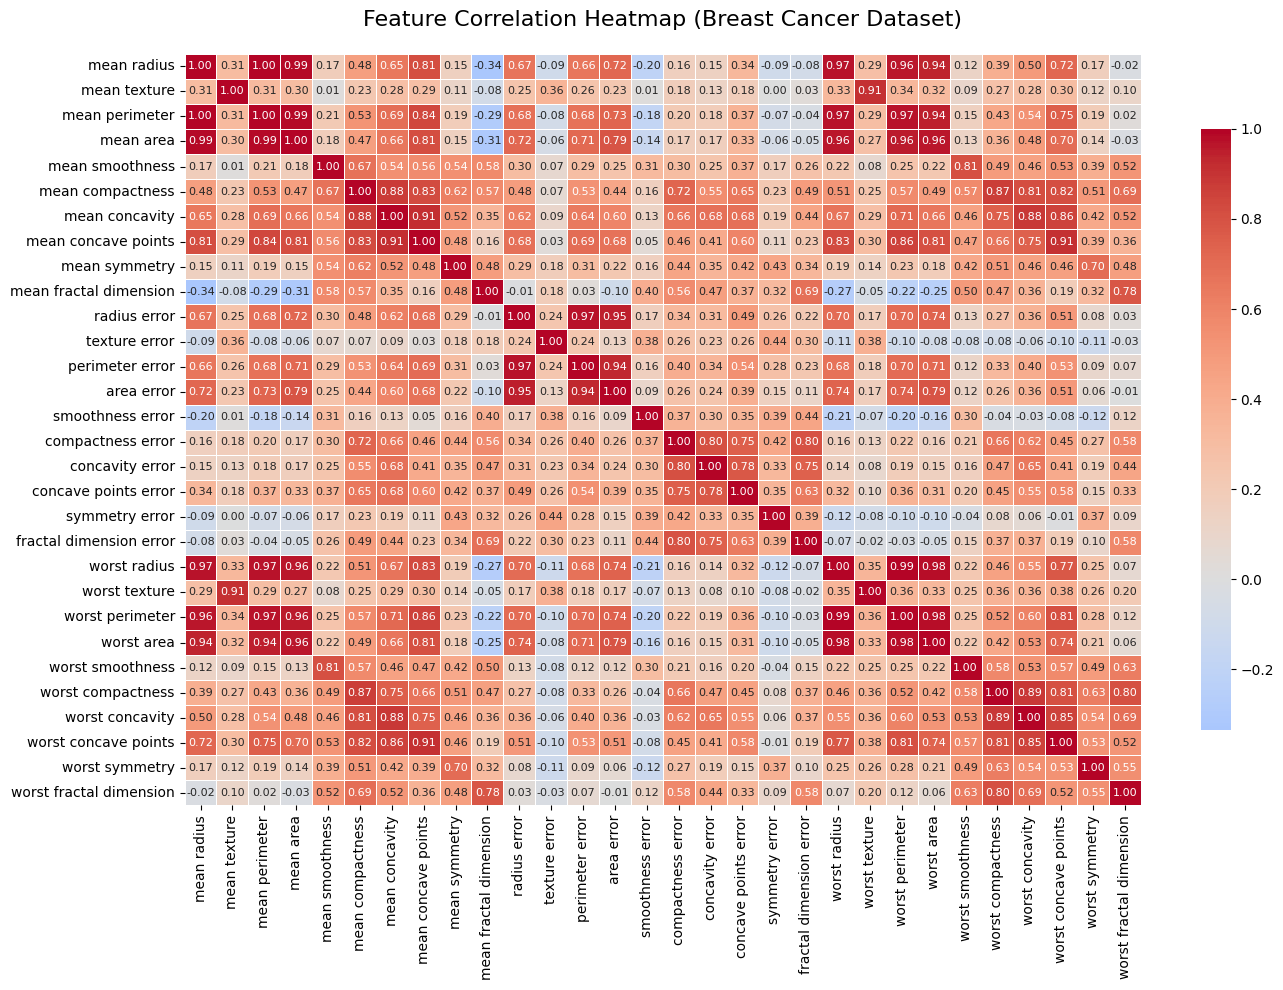

In [51]:
import seaborn as sns

corr = X_train.corr()

plt.figure(figsize=(14, 10))

# Heatmap
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Feature Correlation Heatmap (Breast Cancer Dataset)", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

In [24]:
def top_correlations(df, n=10):
    """
    Returns the top n highest absolute correlations (excluding self-correlations).

    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with numeric features.
    n : int
        Number of top correlations to return.

    Returns:
    --------
    pd.DataFrame with columns: feature1, feature2, correlation
    """
    corr = df.corr().abs()  # absolute values
    corr_unstacked = corr.unstack()

    corr_unstacked = corr_unstacked[corr_unstacked < 1]

    sorted_corr = corr_unstacked.sort_values(ascending=False).drop_duplicates()

    # Format into DataFrame
    top_pairs = sorted_corr.head(n).reset_index()
    top_pairs.columns = ["feature1", "feature2", "correlation"]

    return top_pairs



In [31]:
# Example usage:
top_corrs = top_correlations(X_train, n=30)
print(top_corrs)

               feature1              feature2  correlation
0        mean perimeter           mean radius     0.997850
1          worst radius       worst perimeter     0.993315
2             mean area           mean radius     0.986609
3             mean area        mean perimeter     0.985985
4          worst radius            worst area     0.983458
5            worst area       worst perimeter     0.976979
6          radius error       perimeter error     0.973560
7        mean perimeter       worst perimeter     0.969674
8        mean perimeter          worst radius     0.969620
9          worst radius           mean radius     0.969134
10      worst perimeter           mean radius     0.963536
11            mean area          worst radius     0.960519
12            mean area            worst area     0.959723
13      worst perimeter             mean area     0.955701
14           area error          radius error     0.951025
15       mean perimeter            worst area     0.9432

There are significant correlation issues in this dataset, suggesting that feature engineering should be performed before building the model. Although RandomForest models are generally more robust to multicollinearity than linear models, high correlations can still lead to misinterpretation of certain features and reduce the reliability of the explanations.

## Shap Analysis

In [7]:
import shap
import matplotlib.pyplot as plt

In [36]:
explainer = shap.Explainer(model_bc, X_train, algorithm="tree")

### Global Explanation

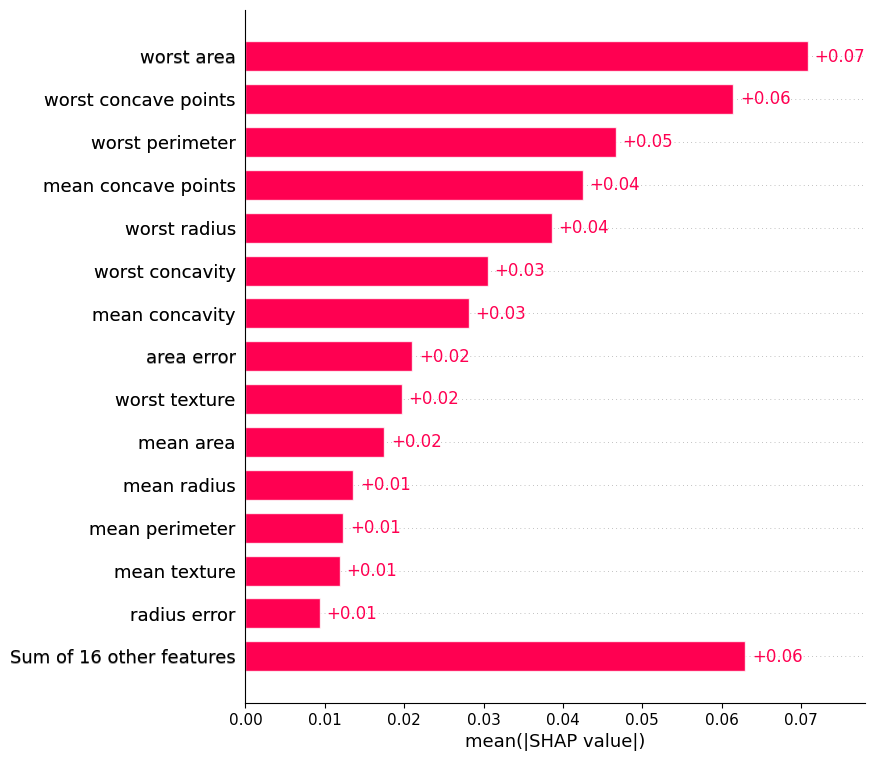

In [38]:
shap_values = explainer(X_test)

shap_values_class1 = shap.Explanation(
    values=shap_values.values[:, :, 1],
    base_values=shap_values.base_values[:, 1],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

shap.plots.bar(shap_values_class1, max_display=15)
plt.show()


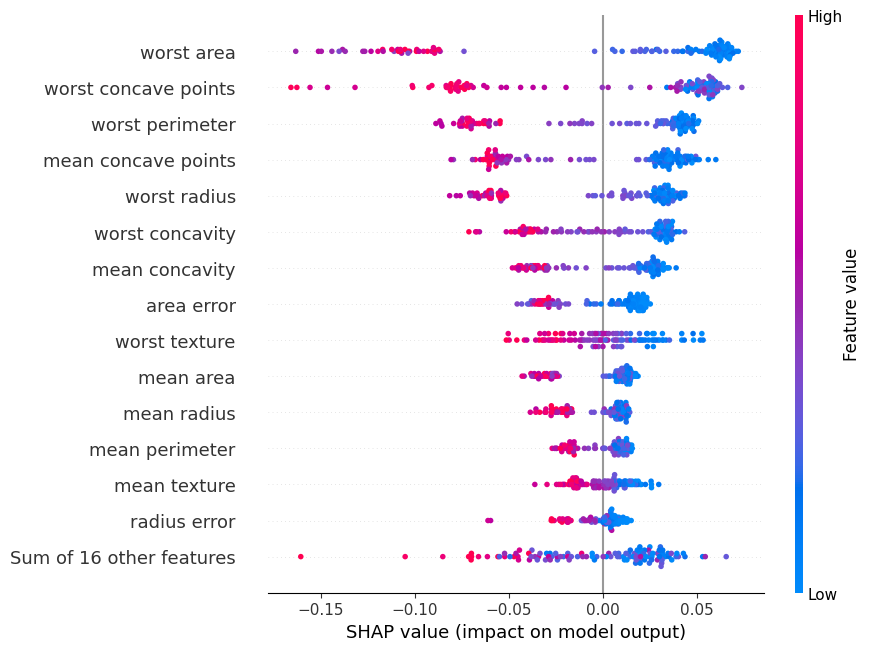

In [10]:
shap.plots.beeswarm(shap_values_class1, max_display=15)
plt.show()

In [48]:
# Global feature importance
mean_abs_shap = np.abs(shap_values.values[:, :, 1]).mean(axis=0)

global_importance = pd.DataFrame({
    "feature": shap_values.feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

print(global_importance)

                    feature  mean_abs_shap
23               worst area       0.070861
27     worst concave points       0.061460
22          worst perimeter       0.046627
7       mean concave points       0.042537
20             worst radius       0.038613
26          worst concavity       0.030522
6            mean concavity       0.028109
13               area error       0.021020
21            worst texture       0.019730
3                 mean area       0.017476
0               mean radius       0.013574
2            mean perimeter       0.012328
1              mean texture       0.011869
10             radius error       0.009383
25        worst compactness       0.009280
24         worst smoothness       0.007415
12          perimeter error       0.006902
28           worst symmetry       0.006748
15        compactness error       0.005693
4           mean smoothness       0.004991
16          concavity error       0.003872
29  worst fractal dimension       0.003209
5          

### Local Explanation

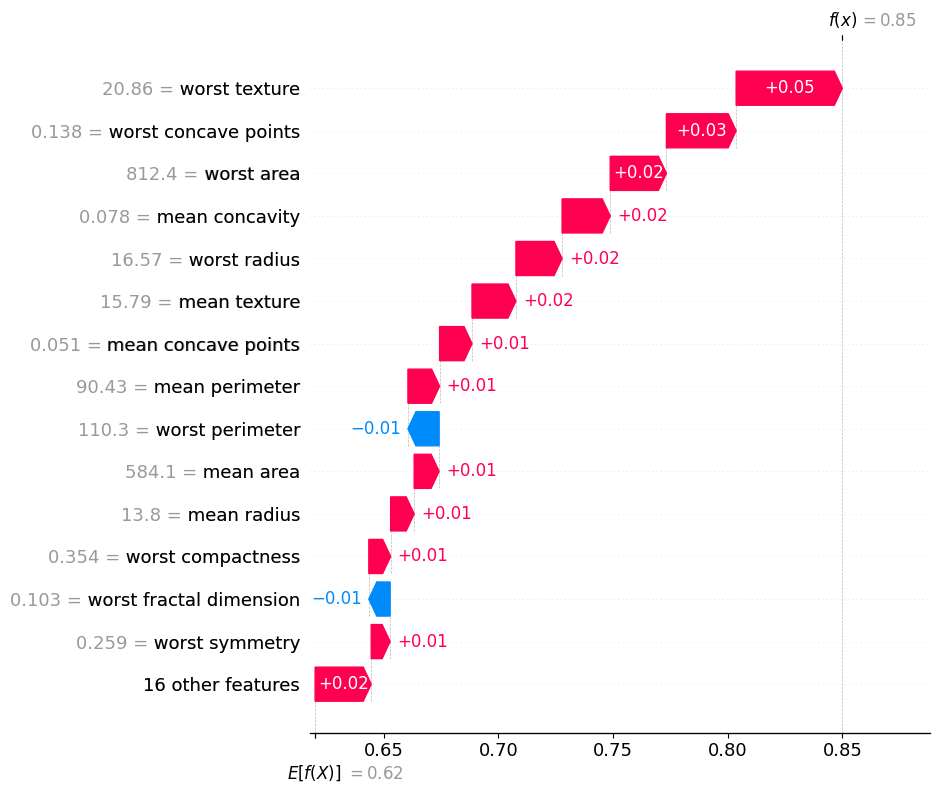

In [11]:

# Single instance only
ex = explainer(focus_instance_bc)

vals = ex.values[0, :, 1]
base = ex.base_values[0, 1]

exp1 = shap.Explanation(
    values=vals,
    base_values=base,
    data=focus_instance_bc.iloc[0].values,
    feature_names=list(X.columns)
)
shap.plots.waterfall(exp1, max_display=15)
plt.show()

In [34]:
instance_importance = pd.DataFrame({
    "feature": exp1.feature_names,
    "value": exp1.data,
    "shap_value": exp1.values
}).sort_values(by="shap_value", key=abs, ascending=False)

pd.set_option("display.max_rows", None)
print(instance_importance)

                    feature       value  shap_value
21            worst texture   20.860000    0.046320
27     worst concave points    0.138300    0.030429
23               worst area  812.400000    0.024513
6            mean concavity    0.077890    0.021000
20             worst radius   16.570000    0.020125
1              mean texture   15.790000    0.019165
7       mean concave points    0.050690    0.014143
2            mean perimeter   90.430000    0.013805
22          worst perimeter  110.300000   -0.013587
3                 mean area  584.100000    0.010873
0               mean radius   13.800000    0.010265
25        worst compactness    0.354200    0.009524
29  worst fractal dimension    0.103000   -0.009291
28           worst symmetry    0.258900    0.008252
5          mean compactness    0.128000    0.007878
26          worst concavity    0.277900    0.004039
18           symmetry error    0.020950    0.003968
15        compactness error    0.022040    0.003440
24         w

In [47]:
df_train= X_train.copy()
df_train["target"] = y_train.values

threshold = 25.22
df_train["texture_group"] = pd.cut(
    df_train["worst texture"],
    bins=[-float("inf"), threshold, float("inf")],
    labels=[f"<= {threshold}", f"> {threshold}"]
)

# Compute percentage class distribution in each group
dist = (
    df_train.groupby("texture_group")["target"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percentage")
    .reset_index()
)

print(dist)

  texture_group  target  percentage
0      <= 25.22       1   83.333333
1      <= 25.22       0   16.666667
2       > 25.22       0   57.709251
3       > 25.22       1   42.290749


/tmp/ipython-input-1001663874.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby("texture_group")["target"]


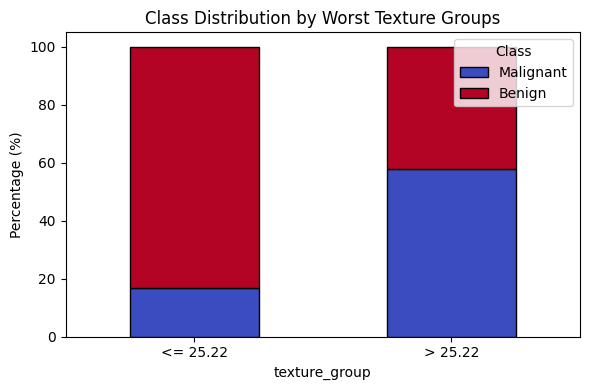

In [49]:
plot_data = dist.pivot(index="texture_group", columns="target", values="percentage")

plot_data = plot_data.rename(columns={0: "Malignant", 1: "Benign"})

# Plot stacked bar chart
ax = plot_data.plot(
    kind="bar",
    stacked=True,
    figsize=(6,4),
    colormap="coolwarm",
    edgecolor="black"
)

plt.ylabel("Percentage (%)")
plt.title("Class Distribution by Worst Texture Groups")
plt.xticks(rotation=0)
plt.legend(title="Class", loc="upper right")
plt.tight_layout()

plt.show()

From the SHAP analysis of this instance, it is clear that Worst Texture played the leading role, shifting the probability toward a benign classification by about 5%. However, this feature is only the ninth most important globally according to the overall SHAP values, and it does not even appear among the top drivers in the model’s own feature importance scores. This indicates that we are dealing with one of those edge cases where the model struggles to prioritize features consistently. Moreover, when we look at the distribution of the texture groups (above vs. below the median), we see a sharp difference in class proportions between malignant and benign. In our case, Patient X’s Worst Texture value of 20.86 falls below the median, a region where the class distribution is roughly 83% benign and 17% malignant. This explains why the model was biased toward predicting benign in this instance.

Additionally, worst concave points usually have a strong negative orientation, meaning that high values typically push predictions toward malignant. However, for Patient X this feature showed a +0.03 SHAP value (≈3% positive), which instead pushed the model toward benign. This reversal highlights that the model failed to apply its usual global logic consistently in this case.

In addition, several key medical indicators that are globally influential were minimized or overlooked in this particular prediction. Specifically:

	•	Worst perimeter → normally among the top global features and model internal feature importance scores, but locally had little influence and did not steer the prediction strongly.

	•	Worst concavity → a known malignancy indicator, but for Patient X its contribution was muted.

	•	Area error → globally ranked as an important factor, yet it played almost no role in the model’s local decision.

Overall, the comparison between the model’s feature importance scores and the global SHAP values reveals a clear discrepancy at the individual level. This inconsistency leads the model to misinterpret key signals and ultimately place undue priority on predicting a benign outcome.


## Lime

In [12]:
!pip install lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [52]:
from lime.lime_tabular import LimeTabularExplainer


In [55]:
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['malignant', 'benign'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

exp = explainer.explain_instance(
    data_row=focus_instance_bc.iloc[0].values,
    predict_fn=model_bc.predict_proba,
    num_features=15
)

print("Local LIME explanation (toward class probabilities):")
for feat, weight in exp.as_list(label=1):  # label=1 => benign
    print(f"{feat:60s}  {weight:+.4f}")



Local LIME explanation (toward class probabilities):
worst texture <= 21.05                                        +0.0594
mean texture <= 16.17                                         +0.0305
0.10 < worst concave points <= 0.16                           +0.0206
0.25 < worst symmetry <= 0.28                                 +0.0197
worst compactness > 0.34                                      -0.0187
0.23 < worst concavity <= 0.39                                -0.0182
0.32 < radius error <= 0.47                                   +0.0178
0.06 < mean concavity <= 0.13                                 -0.0157
24.72 < area error <= 43.73                                   +0.0151
0.02 < concavity error <= 0.03                                -0.0130
worst fractal dimension > 0.09                                -0.0128
fractal dimension error > 0.00                                +0.0118
85.98 < mean perimeter <= 103.75                              -0.0104
0.02 < compactness error <= 0.03     

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


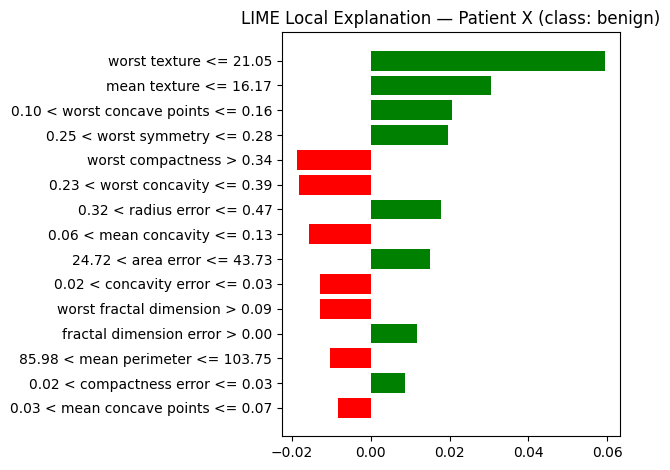

P(malignant)=0.150, P(benign)=0.850


In [57]:

fig = exp.as_pyplot_figure(label=1)
plt.title("LIME Local Explanation — Patient X (class: benign)")
plt.tight_layout()
plt.show()

probs = model_bc.predict_proba(focus_instance_bc)[0]
print(f"P(malignant)={probs[0]:.3f}, P(benign)={probs[1]:.3f}")

There is a interesting pattern that worst texture still most determinant pattern but mean texture also very dominant in this case. However, according to the feature importance score we are knowing that shap based features is most important ones to build the model. Thus, we can say that texture related features overemphasized in this case while shape related features stayed minimized.
Additionally, negative features like worst compactness , worst concavity